<a href="https://colab.research.google.com/github/joaoflauzino/music_style/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Neste projeto foram coletadas letras de músicas do site "vagalume.com.br" com o objetivo de predizer a categoria de uma música baseada na letra. 

As etapas realizadas são:

- Limpeza do texto
- Criação de novas variáveis e manipulações gerais
- Análises descritivas
- Avaliação das categorias de músicas
- Criação do modelo
- Avaliação dos resultados

In [10]:
## Importando bibliotecas
import pandas as pd
import os
import numpy as np
import pickle5 as pickle

# Arquivos 
from google.colab import files
from google.colab import drive

# Pré-Processamento
import re
from unidecode import unidecode 
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords 
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualização
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import fasttext
from sklearn.cluster import KMeans


# Validação modelo
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import silhouette_score

# Ignorando alguns erros
import warnings
warnings.filterwarnings("ignore")

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Leitura da Base

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
with open('/content/drive/My Drive/Datasets/songs.pkl', "rb") as fh:
  df = pickle.load(fh)

In [15]:
# Lendo base
# data.head()
#df = pd.read_pickle('/content/drive/My Drive/Datasets/songs.pkl')

In [18]:
df[(df['singer'] == 'Anitta') & (df['is_pt'] != 'Tradução ') & (df['category'] == 'Funk Carioca')].head(30)

,singer,singer_link,category,category_link,music_name,music_link,lyrics,is_pt
2605,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Desce Pro Play (PA PA PA),/anitta/desce-pro-play-pa-pa-pa.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2607,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Cobertor (Part. Projota),/anitta/cobertor-part-projota.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2608,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Meiga e Abusada,/anitta/meiga-e-abusada.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2609,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,"Combatchy (feat. Lexa, Luisa Sonza & Rebecca)",/anitta/combatchy-feat-lexa-luisa-sonza-rebecc...,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2610,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Some Que Ele Vem Atrás (Part. Marília Mendonça),/anitta/some-que-ele-vem-atras-part-marilia-me...,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2613,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Mulher,/anitta/mulher.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2614,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Bang,/anitta/bang.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2615,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Show Das Poderosas,/anitta/show-das-poderosas.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2617,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Eu Vou Ficar,/anitta/eu-vou-ficar.html,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM
2619,Anitta,/anitta/,Funk Carioca,/browse/style/funk-carioca.html,Totalmente Demais (Part. Duduzinho),/anitta/totalmente-demais-participacao-especia...,"<div data-plugin=""googleTranslate"" id=""lyrics""...",Vagalume.FM


In [19]:
# Checando quantidade de linhas e colunas
df.shape

(11030, 8)

## Limpeza do Texto

In [20]:

# Palavra específicas que gostaria de excluir
stops = ['pra', 'pro', 'vou', 'deu', 'igual']

# Função para limpeza de texto
def transform_text(tokens):
    # Removendo caracteres do html
    tokens = tokens.replace('<div data-plugin="googleTranslate" id="lyrics">', '').replace('</div>', '').replace('<br/>', " ")
    # criando dicionário das stopwords
    stop_words_ = STOP_WORDS.union(stopwords.words('portuguese'))
    stop_words = [unidecode(stop).lower() for stop in stop_words_] + stops
    # Removendo os acentos
    tokens = unidecode(tokens)
    # Removendo links https e caracteres especiais
    tokens = re.sub("(@[A-Za-z0-9]+)|(_[A-Za-z0-9]+)", " ", tokens).lower()
    # Removendo pontuação
    tokens = re.sub('['+string.punctuation+']', '', tokens)
    # Substituindo vários espaços por um só
    tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
    # Removendo digitos
    tokens = ''.join([i for i in tokens if not i.isdigit()])
    # Removento todos caracteres solitários
    tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
    # Quebrando as sentenças em tokens
    tokens = tokens.split()
    # Removendo stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Concatenando sentença tratada
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Retira palavras repetidas em uma sentença
def unique_list(l):
    ulist = []
    for x in l:
        if x not in ulist:
            ulist.append(x)
    return ulist

# Unificar classes
def classes(x):
    if x == 'Gospel/Religioso':
        return 'Religioso'
    elif x == 'Funk Carioca':
        return 'Funk'
    else:
        return x

In [24]:
%%time
df['Transformed'] = df['lyrics'].apply(lambda x: transform_text(x))

CPU times: user 32.9 s, sys: 391 ms, total: 33.3 s
Wall time: 33.5 s


In [25]:
print("ENTRADA: ", df['lyrics'][0])
print('\n')
print("SAÍDA: ", df['Transformed'][0])

ENTRADA:  <div data-plugin="googleTranslate" id="lyrics">Se dirigir, não beba!<br/>Mas se for beber, me chame meu irmão<br/><br/>Saia da rotina,<br/>Então caia na folia<br/>Tem festa, festa!<br/><br/>Hoje a noite tá bombando<br/>Mulherada desfilando<br/>Eu quero festa, festa<br/><br/>Todo santo dia<br/>É a mesma agonia<br/>Vou te dizer<br/>Fazer o que?<br/><br/>O celular tá ocupado<br/>O povo estressado<br/>Sabe o que vou fazer?<br/><br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou tomar todas no bar!!<br/><br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou tomar todas no bar!!<br/><br/>Saia da rotina,<br/>Então caia na folia<br/>Tem festa, festa!<br/><br/>Hoje a noite tá bombando<br/>Mulherada desfilando<br/>Eu quero festa, festa<br/><br/>Todo santo dia<br/>É a mesma agonia<br/>Vou te dizer<br/>Fazer o que?<br/><br/

## Manipulações gerais

In [26]:
# Considerando apenas músicas brasileiras
df_br = df[(df['is_pt'] != 'Tradução ')].copy()

## Análise descritiva

Neste caso, tem-se as categorias consideradas pelo vagalume que totalizam em 69. Talvez o ideal reduzir esse número de classes. Um exemplo de redução seria:

- Funk e Funk Carioca -> Funk

Sabemos que na prática pode não existir palavras ou sentenças que consigam diferenciar Funk de Funk Carioca, portanto, vamos aplicar essa regra na base

In [27]:
# Categorias
df_br['category'].unique()

array(['Axé', 'Black Music', 'Blues', 'Bossa Nova', 'Classic Rock',
       'Clássico', 'Dance', 'Disco', 'Electro Swing', 'Electronica',
       'Emocore', 'Fado', 'Folk', 'Forró', 'Funk', 'Funk Carioca',
       'Gospel/Religioso', 'Gótico', 'Grunge', 'Hard Rock', 'Hardcore',
       'Heavy Metal', 'Hip Hop', 'House', 'Indie', 'Industrial',
       'Infantil', 'Instrumental', 'J-Pop/J-Rock', 'Jazz', 'Jovem Guarda',
       'K-Pop/K-Rock', 'Kizomba', 'Metal', 'MPB', 'Músicas Gaúchas',
       'New Age', 'New Wave', 'Pagode', 'Piano Rock', 'Pop', 'Pop/Punk',
       'Pop/Rock', 'Pós-Punk', 'Progressivo', 'Psicodelia', 'Punk Rock',
       'Rap', 'Reggae', 'Reggaeton', 'Regional', 'Rock',
       'Rock Alternativo', 'Romântico', 'Samba', 'Samba Enredo',
       'Sertanejo', 'Ska', 'Soft Rock', 'Soul Music', 'Surf Music',
       'Tecnopop', 'Trance', 'Trap', 'Trilha Sonora', 'Trip-Hop',
       'Tropical House', 'Velha Guarda', 'World Music'], dtype=object)

In [28]:
# Quantidade por grupo
df['category'].value_counts()

Soft Rock        382
Romântico        357
Samba Enredo     355
Jovem Guarda     328
Velha Guarda     311
                ... 
Lo-fi             22
Trip-Hop          15
Trap               5
Metal              4
Electro Swing      4
Name: category, Length: 76, dtype: int64

In [29]:
df_br_ = df_br[df_br['category'].isin(['Axé', 'Gospel/Religioso', 'Samba', 'Pagode', 'Pop/Rock', 'MPB', 'Hip Hop', 'Heavy Metal', 'Funk', 'Funk Carioca', 'Rock Alternativo', 'Sertanejo'])]
df_br_['category'] = df_br_['category'].apply(lambda x: classes(x))
df_br_['category'].unique()

array(['Axé', 'Funk', 'Religioso', 'Heavy Metal', 'Hip Hop', 'MPB',
       'Pagode', 'Pop/Rock', 'Rock Alternativo', 'Samba', 'Sertanejo'],
      dtype=object)

In [30]:
df_br_['category'].value_counts()

Axé                 253
Samba               215
Religioso           194
MPB                 184
Pagode              158
Sertanejo           114
Funk                100
Rock Alternativo     19
Hip Hop               9
Pop/Rock              5
Heavy Metal           1
Name: category, dtype: int64

In [31]:
# Filtrando classes que tenha pelo menos 30 registros
df_br_ = df_br_.groupby('category').filter(lambda x: len(x) >= 100)

## Observação

Na nuvem de palavras percebe-se que ainda existe algumas palavras que podem ser consideradas como stopwords, porém, vamos deixar na base e observar como os modelos vão se comportar. Como se trata de música e em muitos estilos temos algumas "peculiaridades", não podemos fazer algumas suposições de imediato.

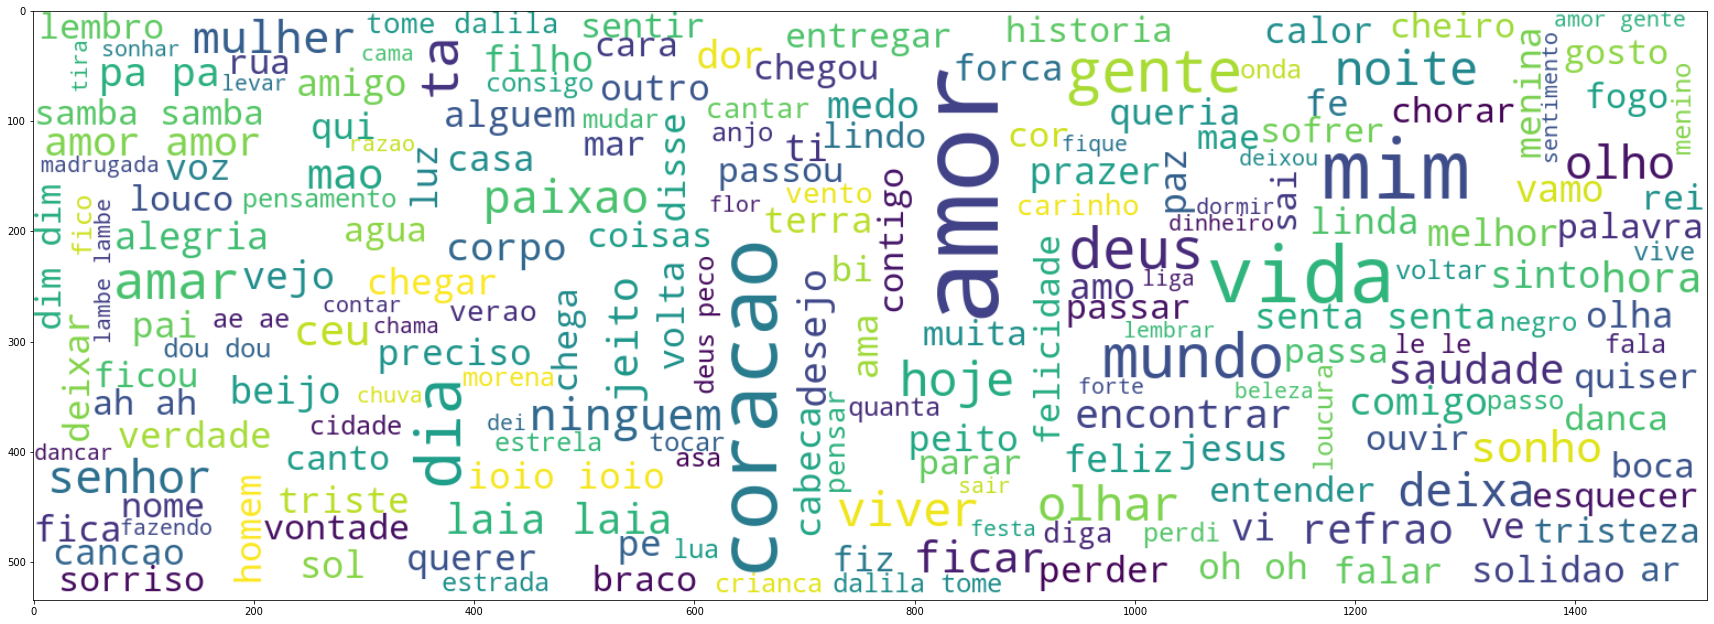

In [32]:
# Nuvem para todas as palavras
fig, ax = plt.subplots(1, 1, figsize=(30,30))
text = " ".join(review for review in df_br_[(df_br_['is_pt'] != 'Tradução ')]['Transformed'])
ax.imshow(WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text), interpolation="bilinear")

# Diferentes estilos de musicas ocasionam em uma maior ou menor diversidade de palavras? 

Para responder esta pergunta, foi realizada a redução de palavras duplicadas em cada letra. Para melhor exemplificação:

- Supõe-se que tem uma música que contém 30 palavras, sendo que 5 são duplicadas e outra música que contém 100 palavras e apenas 10 duplicadas. Retirando as duplicidades, tem - se 20 palavras na primeira e 80 na segunda. Neste caso, a segunda música contém uma diversidade maior de palavras utilizadas.

- De acordo com os histogramas gerados, percebe-se que por exemplo, o MPB contém músicas com maior diversidade do que as outras


In [33]:
%%time
df_br_['Reduce'] = df_br_['Transformed'].apply(lambda x: ' '.join(unique_list(x.split())))
df_br_['len'] = df_br_['Reduce'].apply(lambda x: len(x))

CPU times: user 45.2 ms, sys: 947 µs, total: 46.2 ms
Wall time: 48.6 ms


In [34]:
df_br_['category'].unique()

array(['Axé', 'Funk', 'Religioso', 'MPB', 'Pagode', 'Samba', 'Sertanejo'],
      dtype=object)

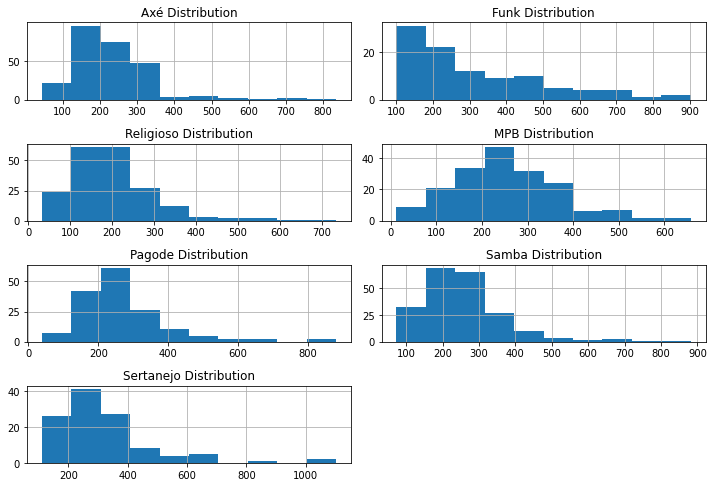

CPU times: user 1.41 s, sys: 139 ms, total: 1.55 s
Wall time: 1.41 s


In [35]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()

def draw_histograms(df, categorys, n_rows, n_cols):
    fig=plt.figure(figsize=(10,10))

    for i, var_name in enumerate(categorys):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[df['category']== var_name]['len'].hist(bins = 10, ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    

draw_histograms(df_br_, categorys, 6, 2)
    

In [36]:
categorys

array(['Axé', 'Funk', 'Religioso', 'MPB', 'Pagode', 'Samba', 'Sertanejo'],
      dtype=object)

# Aplicando modelos supervisionados

 Nesta abordagem, foram utilizados os seguintes modelos:

- Random Forest 
- XgBoost
- FasText

As métricas de validação F1 Score, Acurácia e Precisão ficaram abaixo do esperado. O que podemos concluir é que talvez nesse cenário e nesses dados, a utilização das letras para representar os estilos musicais não seja tão viável. Outro ponto interessante é que talvez não existam palavras ou combinação das mesmas (n-gram) que sejam capazes de discriminar um estilo musical do outro... 



In [37]:
# Transformando rótulos em números
df_br_['fast_category'] = df_br_['category']
le = preprocessing.LabelEncoder()
le.fit(df_br_['category'].unique())
df_br_['category'] = le.transform(df_br_['category'])

In [38]:
df_br_['category'].unique()

array([0, 1, 4, 2, 3, 5, 6])

In [39]:
# Treino e teste
X_treino, X_valid, y_treino, y_valid = train_test_split(df_br_['Transformed'], df_br_['category'], test_size=0.3)

In [47]:
# Aplicando TDFIF em treino e teste
vect = TfidfVectorizer(max_features=60, min_df=2, ngram_range=(1,2))
X_treino_vect = vect.fit_transform(X_treino)
X_valid_vect = vect.transform(X_valid)

### Random Forest

In [48]:
random = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, n_jobs = 6)
random.fit(X_treino_vect.todense(), y_treino)
predictions_random = random.predict(X_valid_vect.todense())

In [49]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_random, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_random))
print("Precisão: ", precision_score(y_valid, predictions_random, average='macro'))
print('Recall: ', recall_score(y_valid, predictions_random, average='macro'))

F1:  0.2866250717385929
ACC:  0.3251366120218579
Precisão:  0.30836771262138557
Recall:  0.2904365032475632


### XGBOOST

In [50]:
clf = GradientBoostingClassifier(n_estimators= 1000, learning_rate=0.03, max_depth=1, random_state=0)
clf.fit(X_treino_vect.todense(), y_treino)
predictions_xgboost = clf.predict(X_valid_vect.todense())

In [51]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_xgboost, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_xgboost))
print("Precisão: ", precision_score(y_valid, predictions_xgboost, average='macro'))
print('Recall: ', recall_score(y_valid, predictions_random, average='macro'))

F1:  0.26112668549196244
ACC:  0.2978142076502732
Precisão:  0.26579581194874036
Recall:  0.2904365032475632


### FastText

In [52]:
# Preparando label
df_br_['fast_category'] = df_br_['fast_category'].apply(lambda x: "__label__" + unidecode(x.lower()))

In [58]:
# Escrevendo base em arquivo txt
with open('/content/drive/My Drive/Datasets/music.txt', 'w') as f:
    f.write(
        df_br_[['fast_category', 'Transformed']].to_string(header = False, index = False)
    )

In [59]:
# Separando entre treino e teste
os.system('head -n 852 /content/drive/My Drive/Datasets/music.txt > /content/drive/My Drive/Datasets/music_train.txt')
os.system('tail -n 364 /content/drive/My Drive/Datasets/music.txt > /content/drive/My Drive/Datasets/music_test.txt')

512

In [60]:
# Treinando modelo
model = fasttext.train_supervised(input="/content/drive/My Drive/Datasets/music_train.txt", epoch=100, lr=0.335, wordNgrams=3, bucket=200000, dim=60, loss='hs')
model.save_model('/content/drive/My Drive/Datasets/model_music.bin')

In [61]:
# Testando
model.test('/content/drive/My Drive/Datasets/music_test.txt')

(11, 0.18181818181818182, 0.18181818181818182)

# Aplicando regras não supervisionadas

Já que não foi possível predizer o estilo musical através das letras, outra ideia seria aplicar algum algoritmo de agrupamento. Caso seja possível extrair grupos dessa base, podemos comparar os grupos extraídos com os estilos musicais fornecidos pelo site para ver se existe algum sentido ou não.

Porém, ao aplicar o algoritmo K-means chegamos a conclusão que não é possível formar grupos consistentes, já que a silhueta ficou abaixo de 0.18 para as variações de 2 a 100 grupos. Lembrando que a silhueta varia de -1 a 1, quanto mais próximo de 1 melhor a qualidade dos grupos 

In [62]:
# Aplicando tfidf para os textos
vect = TfidfVectorizer(max_features=60, min_df=2, ngram_range=(1,2))
X = vect.fit_transform(df_br_['Transformed'])

In [63]:
# Aplicando K-means utilizando de 2 a 100 grupos
k = []
silhueta = []
for i in range(2,100):
    kmeans = KMeans(n_clusters=i).fit(X)
    k.append(i)
    silhueta.append(silhouette_score(X, kmeans.labels_))

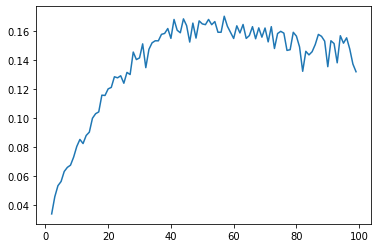

In [64]:
# Avaliando a silhueta
plt.figure()
plt.plot(k,silhueta)
plt.show()

## Conclusão

Através da abordagem supervisionada, conclui-se que não há evidências de que nessa base seja possível prever o estilo musical através das letras. Outro ponto importante é que pela abordagem não-supervisionada não foi possível identificar "grupos musicais".

Talvez os próximos passos sejam aplicar outros algoritmos de clusterização como por exemplo: LDA e DBSCAN. 